# Build Neural Network definition from code

In this example we should how to build a `NetworkDefinition` directly from Python.

If you intend to use a model that is trained using a library like Keras, PyTorch, or Tensorflow you should look at the notebooks that show how to import models into OMLT.

## Library Setup

Start by importing the libraries used in this project:

 - `pyomo`: the algebraic modeling language for Python, it's used to define the optimization model passed to the solver
 - `numpy`: a general-purpose numerical library
 
We import the following classes from OMLT:

 - `NetworkDefinition`: class that contains the nodes in a Neural Network
 - `InputLayer`, `DenseLayer`: the two types of layers used in this example
 - `IndexMapper`: used to reshape the data between layers

In [1]:
import pyomo.environ as pyo
import numpy as np

from omlt.neuralnet import NetworkDefinition
from omlt.neuralnet.layer import InputLayer, DenseLayer, IndexMapper

The following imports are needed to display graphics in this notebook.

In [2]:
from IPython.display import Image

## Neural Network creation

We start by creating the Neural Network definition. In this example, the input of the network is four variables in a 2 by 2 grid with bounds in $[-1, 1]$.

In [3]:
net = NetworkDefinition(scaled_input_bounds={(0,0):(-1.0, 1.0), 
                                             (0,1):(-1.0, 1.0),
                                             (1,0):(-1.0, 1.0),
                                             (1,1):(-1.0, 1.0)})

We can see that when the network is created it contains no layers.

In [4]:
list(net.layers)

[]

We can now add the input layer. We specify that the input is a 2 by 2 matrix.

In [5]:
input_layer = InputLayer([2, 2])

Graphically, we represent the input layer as follows:


Notice the input has a double border since the input has dimension 2.

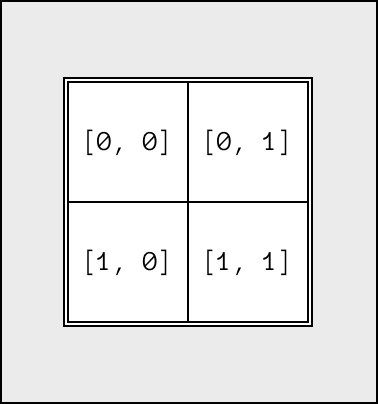

In [6]:
Image(filename='../images/input-layer.png', height=300)

We then add the node to the layer

In [7]:
net.add_layer(input_layer)

Now we add a dense layer to the network. A dense layer is a layer where each output node is connected to all input nodes. 

The output of the dense layer, before activation, is given by the following equation:

$$
\hat{Y} = WX + b
$$

where $\hat{Y} \in \mathbb{R}^{N \times L}$, $W \in \mathbb{R}^{N \times M}$, $X \in \mathbb{R}^{M \times L}$ and $b \in \mathbb{R}^N$.

In this case the activation function is linear which means that the output of the layer is $Y = \hat{Y}$.

A dense layer needs to know its input and output sizes to validate the size of the weights and biases.
In this example, the input is $X \in \mathbb{R}^{2 \times 2}$, the output is $Y \in \mathbb{R}^{2 \times 1}$, the weights are $W \in \mathbb{R}^{2 \times 1}$ and the biases are $b \in \mathbb{R}^2$.

Graphically, we represent this layer as follows. In this image we show that the result of the matrix multiplication and addition is passed to the linear activation function.

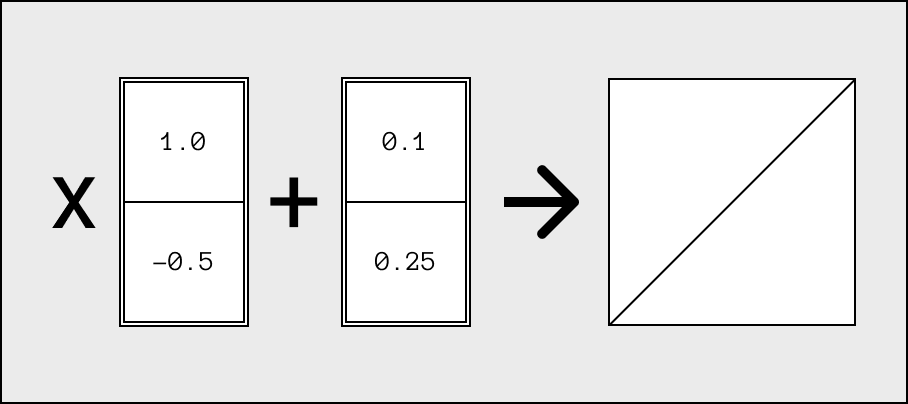

In [8]:
Image(filename='../images/dense-layer-0.png', height=250)

In [9]:
dense_layer_0 = DenseLayer(
    input_size=input_layer.output_size,
    output_size=[2, 1],
    activation="linear",
    weights=np.array([[1.0], [-0.5]]),
    biases=np.array([[0.1], [0.25]])
)

We add the layer to the network and then connect the output of the input layer to the input of this layer.

In [10]:
net.add_layer(dense_layer_0)
net.add_edge(input_layer, dense_layer_0)

Now the network looks as follows, where the output of the input layer becomes the input of the dense layer.

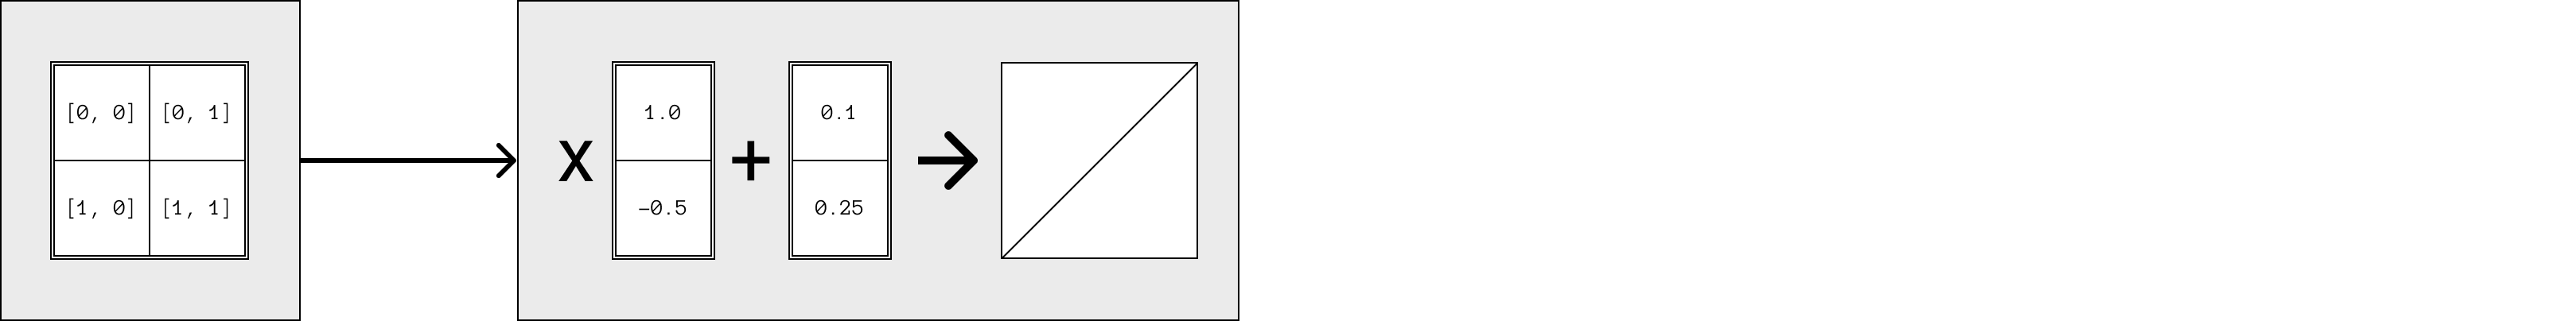

In [11]:
Image(filename='../images/network-structure-0.png', height=200)

In the final layer of our simple network we use a dense layer again. This time we want to "flatten" the output of the previous layer into a vector with the same number of elements.
We achieve this by defining an `IndexMapper`. This object is used to map indices from differently-sized matrices, effectively changing the shape of the output of one layer to match the input of the other layer.

In [12]:
transformer = IndexMapper([2, 1], [2])

for i in range(2):
    print(f"Input index {i} is output index {transformer([i])}")

Input index 0 is output index (0, 0)
Input index 1 is output index (1, 0)


This layer also uses a different type of activation function: the Rectified Linear Unit (ReLU) function. This function changes the output $Y$ of the layer to $Z$ defined as:

$$
Y = \max(\hat{Y}, 0)
$$

Graphically, the activation function looks like the following:

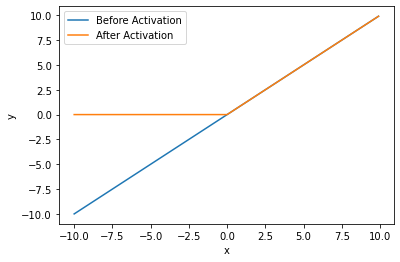

In [13]:
import matplotlib.pyplot as plt

x = np.arange(-10, 10, 0.1)
y = x
z = np.maximum(0, y)

plt.plot(x, y, label='Before Activation')
plt.plot(x, z, label='After Activation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

We can now define the final dense layer, we specify `activation="relu"` to let OMLT know that the activation function of this layer is ReLU.

In [14]:
dense_layer_1 = DenseLayer(
    input_size=[2],
    output_size=[1],
    activation="relu",
    weights=np.array([[2.0], [-1.0]]),
    biases=np.array([[0.0]]),
    input_index_mapper=transformer,
)

Graphically, we represent the layer as follows. Notice that this time the activation function is a ReLU. Also notice that the weights and biases are 1-dimensional tensors (represented as cells with a single border), this is achieved by using the `IndexMapper` to "flatten" the 2-dimensional tensor output of the previous layer.

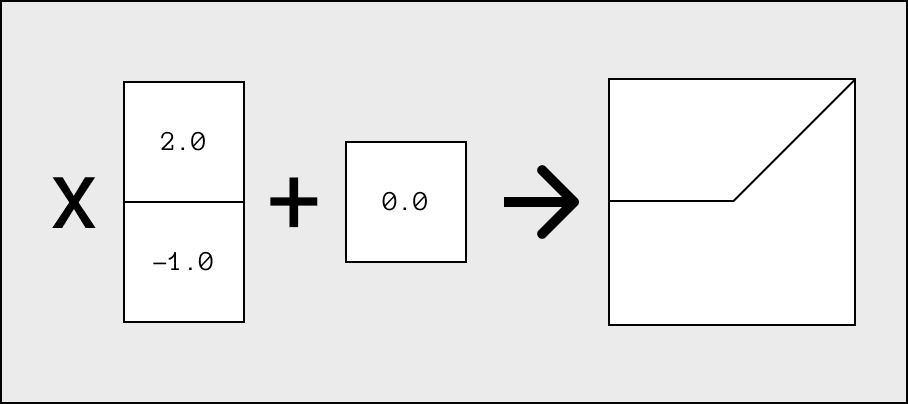

In [15]:
Image(filename='../images/dense-layer-1.png', height=250)

We can then connect the output of the previous dense layer (`dense_layer_0`) to the input of this dense layer (`dense_layer_1`).

In [16]:
net.add_layer(dense_layer_1)
net.add_edge(dense_layer_0, dense_layer_1)

The final network looks as follows. We explicitly show the output of the network as a single-element 1-dimensional tensor, this is for illustration purpose only. The network definition does not include an output layer type.

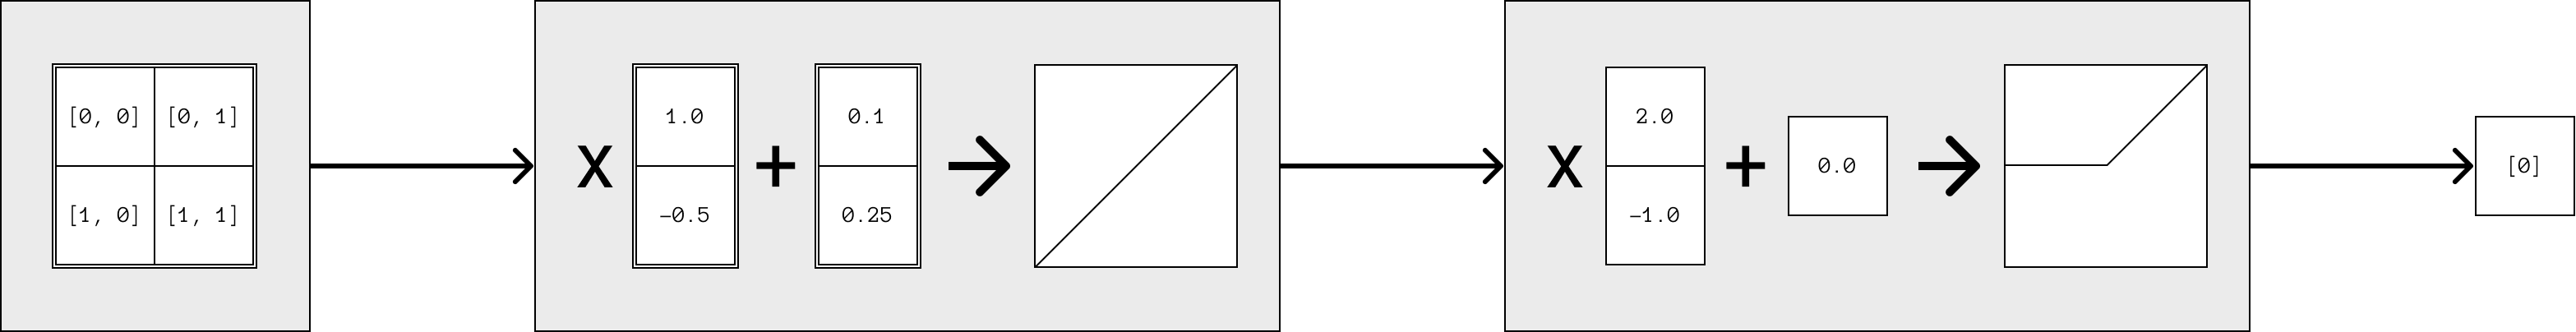

In [17]:
Image(filename='../images/network-structure-1.png', height=200)

## Building the optimization model



We are now ready to build the optimization model using the neural network we just defined.

We start by importing `OmltBlock` and `ReLUBigMFormulation`:

 - `OmltBlock`: a special type of Pyomo block that contains the variables and constraints of our machine-learning model
 - `NeuralNetworkFormulation`: used to create the Pyomo constraints and variables that represent the given neural network

In [18]:
from omlt import OmltBlock
from omlt.neuralnet import ReluBigMFormulation

We then create an empty Pyomo model.

In [19]:
m = pyo.ConcreteModel()

We add the `OmltBlock` to the model. `OmltBlock` is a special type of _Pyomo block_ that is used to automatically build an optimization formulation of a machine learning model. Pyomo blocks are a mechanism to encapsulated and organize constraints in larger optimization models, all variables and constraints are locally scoped to the block (as we will see soon).

In [20]:
m.neural_net = OmltBlock()

We can then instantiate the formulation object passing the neural network definition. This step simply associates the neural network with the formulation and does not create any constraint yet.

In [21]:
formulation = ReluBigMFormulation(net)

We can finally generate the formulation by instructing the `OmltBlock` to build the formulation we specify (in this case, a `NeuralNetworkFormulation`).

In [22]:
m.neural_net.build_formulation(formulation)

### The ReLU Big-M formulation

In this section we explore the formulation that we just created using `NeuralNetworkFormulation` and `OmltBlock`.

All `OmltBlock` define two indexed variables that represent the block input and output variables. You can access them using the `inputs` and `outputs` field of the block you defined (in this example, `m.neural_net`).
Notice that thanks to Pyomo blocks we don't need to worry about name collisions since the input and output variables are locally scope to the block. You can have variables with the same name in your main model.

We print the inputs variable and we can see that they have a 2-dimensional index that corresponds to the diagrams in the previous section. We also see that the variables are initialized with the bounds we passed earlier.

In [23]:
m.neural_net.inputs.pprint()

inputs : Size=4, Index=neural_net.inputs_set
    Key    : Lower : Value : Upper : Fixed : Stale : Domain
    (0, 0) :  -1.0 :     0 :   1.0 : False : False :  Reals
    (0, 1) :  -1.0 :     0 :   1.0 : False : False :  Reals
    (1, 0) :  -1.0 :     0 :   1.0 : False : False :  Reals
    (1, 1) :  -1.0 :     0 :   1.0 : False : False :  Reals


We print the output variables, in this case a single variable. 

In [24]:
m.neural_net.outputs.pprint()

outputs : Size=1, Index=neural_net.outputs_set
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      0 :  None :     0 :  None : False : False :  Reals


#### Input Layer

The input layer doesn't add any constraint. Like all other blocks in a neural network formulation it defines a set of variables `zhat` that represent $\hat{Y}$ (output before activation) and a set of variables `z` that represent output after activation $Y$.

In [27]:
m.neural_net.layer[m.neural_net.layers.at(1)].z.pprint() #Note, the input layer does not have zhat
m.neural_net.layer[m.neural_net.layers.at(2)].zhat.pprint() 

z : Size=4, Index=neural_net.layer[140636360533136].z_index
    Key    : Lower : Value : Upper : Fixed : Stale : Domain
    (0, 0) :  -1.0 :     0 :   1.0 : False : False :  Reals
    (0, 1) :  -1.0 :     0 :   1.0 : False : False :  Reals
    (1, 0) :  -1.0 :     0 :   1.0 : False : False :  Reals
    (1, 1) :  -1.0 :     0 :   1.0 : False : False :  Reals
zhat : Size=2, Index=neural_net.layer[140636360463312].zhat_index
    Key    : Lower  : Value : Upper : Fixed : Stale : Domain
    (0, 0) : [-2.9] :     0 : [3.1] : False : False :  Reals
    (1, 0) : [-2.9] :     0 : [3.1] : False : False :  Reals


We can also see that the block connects input variables with the input layer output variables. This assignment looks superfluous but it's not: if the block inputs variables are different from the neural network input shape, this assignment connects them correctly.

In [28]:
m.neural_net.input_assignment.pprint()

input_assignment : Size=4, Index=neural_net.input_assignment_index, Active=True
    Key    : Lower : Body                                                                     : Upper : Active
    (0, 0) :   0.0 : neural_net.scaled_inputs[0,0] - neural_net.layer[140636360533136].z[0,0] :   0.0 :   True
    (0, 1) :   0.0 : neural_net.scaled_inputs[0,1] - neural_net.layer[140636360533136].z[0,1] :   0.0 :   True
    (1, 0) :   0.0 : neural_net.scaled_inputs[1,0] - neural_net.layer[140636360533136].z[1,0] :   0.0 :   True
    (1, 1) :   0.0 : neural_net.scaled_inputs[1,1] - neural_net.layer[140636360533136].z[1,1] :   0.0 :   True


#### Dense Layer with linear activation

This layer adds the constraints to represent $\hat{Y} = WX + b$ and $Y = \hat{Y}$. In this case, $X$ is the output of the previous layer.

Like in the previous case, this layer defines the `z` and `zhat` variables. Notice how their index dimension matches the diagrams in the previous section.

In [29]:
m.neural_net.layer[m.neural_net.layers.at(2)].z.pprint()
m.neural_net.layer[m.neural_net.layers.at(2)].zhat.pprint()

z : Size=2, Index=neural_net.layer[140636360463312].z_index
    Key    : Lower  : Value : Upper : Fixed : Stale : Domain
    (0, 0) : [-2.9] :     0 : [3.1] : False : False :  Reals
    (1, 0) : [-2.9] :     0 : [3.1] : False : False :  Reals
zhat : Size=2, Index=neural_net.layer[140636360463312].zhat_index
    Key    : Lower  : Value : Upper : Fixed : Stale : Domain
    (0, 0) : [-2.9] :     0 : [3.1] : False : False :  Reals
    (1, 0) : [-2.9] :     0 : [3.1] : False : False :  Reals


Finally, we see the assignment $Y = \hat{Y}$ that represents the linear activation function.

In [30]:
m.neural_net.layer[m.neural_net.layers.at(2)].linear_activation.pprint()

linear_activation : Size=2, Index=neural_net.layer[140636360463312].linear_activation_index, Active=True
    Key    : Lower : Body                                                                                   : Upper : Active
    (0, 0) :   0.0 : neural_net.layer[140636360463312].z[0,0] - neural_net.layer[140636360463312].zhat[0,0] :   0.0 :   True
    (1, 0) :   0.0 : neural_net.layer[140636360463312].z[1,0] - neural_net.layer[140636360463312].zhat[1,0] :   0.0 :   True


#### Dense layer with ReLU activation

The final layer contains a ReLu activation. This layer adds the same constraints as the previous layer to represent $\hat{Y} = WX + b$, in addition it adds additional constraints to represent the ReLU activation function as a Mixed-Integer Program (MIP).

The ReLU activation function is the following:

$$Y = \max(\hat{Y}, 0)$$

Let's start by looking at the variables `z` and `zhat` and the dense layer constraints.

In [31]:
m.neural_net.layer[m.neural_net.layers.at(3)].z.pprint()
m.neural_net.layer[m.neural_net.layers.at(3)].zhat.pprint()
m.neural_net.layer[m.neural_net.layers.at(3)].dense_layer.pprint()

z : Size=1, Index=neural_net.layer[140636334859664].z_index
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      0 :     0 :     0 : [9.1] : False : False :  Reals
zhat : Size=1, Index=neural_net.layer[140636334859664].zhat_index
    Key : Lower  : Value : Upper : Fixed : Stale : Domain
      0 : [-8.9] :     0 : [9.1] : False : False :  Reals
dense_layer : Size=1, Index=neural_net.layer[140636334859664].dense_layer_index, Active=True
    Key : Lower : Body                                                                                                                                  : Upper : Active
      0 :   0.0 : neural_net.layer[140636334859664].zhat[0] - (2.0*neural_net.layer[140636360463312].z[0,0] - neural_net.layer[140636360463312].z[1,0]) :   0.0 :   True


In this case, the output $Y$ cannot be assigned directly to $\hat{Y}$ since the activation function is non-linear.

We start by computing the bounds on the expression $\hat{Y} = WX + b$, $\hat{Y} \in [\hat{Y}^L, \hat{Y}^U]$. The variables $Y^L$ and $Y^U$ are the lower and upper bounds on $Y$ respectively. By definition, $Y^L = 0$. We define $Y^U = \max(\hat{Y}^U, 0)$.

The MIP representation of the ReLU activation function is given by the following equations:

$$Y \geq 0$$

$$Y \geq \hat{Y}$$

$$Y \leq \hat{Y}^U \delta$$

$$Y \leq \hat{Y} - \hat{Y}^L (1 - \delta)$$

where $\delta \in \{0, 1\}$ is a binary variable that equals $1$ when the activation function is in the $0$ region, and is $0$ when the activation function is in the linear region.

We can print the lower and upper bounds on $\hat{Y}$ computed by OMLT. We use a _Pyomo parameter_ for the lower and upper bounds so that they can be updated by performing Feasibility-Based Bounds Tightening or Optimality-Based Bounds Tightening.

In [32]:
m.neural_net.layer[m.neural_net.layers.at(3)]._big_m_lb.pprint()
m.neural_net.layer[m.neural_net.layers.at(3)]._big_m_ub.pprint()

_big_m_lb : Size=1, Index=neural_net.layer[140636334859664]._big_m_lb_index, Domain=Any, Default=-1000000.0, Mutable=True
    Key : Value
      0 : [-8.9]
_big_m_ub : Size=1, Index=neural_net.layer[140636334859664]._big_m_ub_index, Domain=Any, Default=1000000.0, Mutable=True
    Key : Value
      0 : [9.1]


We can also see that OMLT updated the bounds on $Y$.

In [33]:
m.neural_net.layer[m.neural_net.layers.at(3)].z.pprint()

z : Size=1, Index=neural_net.layer[140636334859664].z_index
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      0 :     0 :     0 : [9.1] : False : False :  Reals


We can then print the four MIP constraints:

In [34]:
m.neural_net.layer[m.neural_net.layers.at(3)]._z_lower_bound.pprint()
m.neural_net.layer[m.neural_net.layers.at(3)]._z_lower_bound_zhat.pprint()
m.neural_net.layer[m.neural_net.layers.at(3)]._z_upper_bound.pprint()
m.neural_net.layer[m.neural_net.layers.at(3)]._z_upper_bound_zhat.pprint()

_z_lower_bound : Size=1, Index=neural_net.layer[140636334859664]._z_lower_bound_index, Active=True
    Key : Lower : Body                                   : Upper : Active
      0 :   0.0 : neural_net.layer[140636334859664].z[0] :  +Inf :   True
_z_lower_bound_zhat : Size=1, Index=neural_net.layer[140636334859664]._z_lower_bound_zhat_index, Active=True
    Key : Lower : Body                                                                               : Upper : Active
      0 :  -Inf : neural_net.layer[140636334859664].zhat[0] - neural_net.layer[140636334859664].z[0] :   0.0 :   True
_z_upper_bound : Size=1, Index=neural_net.layer[140636334859664]._z_upper_bound_index, Active=True
    Key : Lower : Body                                                                                                                           : Upper : Active
      0 :  -Inf : neural_net.layer[140636334859664].z[0] - neural_net.layer[140636334859664]._big_m_ub[0]*neural_net.layer[140636334859664].q[0] : 

#### Model output

As we have seen at the beginning of this section, the output of this model can be accessed using the `outputs` variable. The formulation automatically adds a set of constraints to connect the outputs of the last layer to the `outputs` variables.

In [35]:
m.neural_net.output_assignment.pprint()

output_assignment : Size=1, Index=neural_net.output_assignment_index, Active=True
    Key : Lower : Body                                                                  : Upper : Active
      0 :   0.0 : neural_net.scaled_outputs[0] - neural_net.layer[140636334859664].z[0] :   0.0 :   True


## Additional features

Layers provide a function `eval` to evaluate the layer with the given input. The input must be a numpy array of `layer.input_size` size.

We start by defining an input vector of the correct 2 by 2 size.

In [36]:
x = np.diag([1.0, 0.1]) + 0.3
x

array([[1.3, 0.3],
       [0.3, 0.4]])

The input layer simply returns the input as its output since it doesn't represent any operation.

In [37]:
x = input_layer.eval(x)
x

array([[1.3, 0.3],
       [0.3, 0.4]])

The first dense layer performs the $Y = WX + b$ operation. We notice that the output is a 2 by 1 numpy matrix.

In [38]:
x = dense_layer_0.eval(x)
x

array([[1.25],
       [0.35]])

The final dense layer perform the $Y = WX + B$ operation again, with different weights. The output is a vector with only one element.

In [39]:
x = dense_layer_1.eval(x)
x

array([2.15])